1. Import


In [57]:
import pandas as pd
import numpy as np
import pickle
import yaml
import sys
import warnings
from pathlib import Path
from typing import List, Dict, Any

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"모듈 경로 추가 완료: '{module_path}'")

try:
    from src.data_loader import load_data
    from src.user_profiling import (
        compute_item_pops,
        compute_user_novelty,
        compute_user_preference,
        compute_user_gini_impurity
    )
    print("✅ 사용자 정의 'src' 모듈 로드 완료")
except ImportError as e:
    print(f"🚨 오류: 'src' 모듈 로드 실패. {e}")
except Exception as e:
    print(f"🚨 오류: {e}")

✅ 사용자 정의 'src' 모듈 로드 완료


2. Analysis Settings


In [58]:
CONFIG_PATH = "../configs/book_crossing.yaml"

config_path = Path(CONFIG_PATH)
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

DATASET_NAME = config['dataset_name']
SAVE_DIR = Path("../results")
MODEL_NAMES = config['models']
DIVERSIFICATION_MODES = ["None"]
PERSONALIZE_MODES_FOR_BASELINE = ["NP"]
METRIC_NAMES = ["NDCG@10", "Recall@10", "Precision@10", "MRR@10", "Novelty", "CatalogCoverage", "APLT", "ACLT"]
BASELINE_MODE = "None"
TODAY_DATE = pd.Timestamp.now().strftime("%Y%m%d")

print(f"데이터셋 분석 시작: {DATASET_NAME}")

데이터셋 분석 시작: book_crossing


3. Helper function


In [59]:
def load_results_to_dataframe(
    model_names: List[str],
    diversification_modes: List[str],
    personalize_modes: List[str],
    dataset: str,
    save_dir: str
) -> pd.DataFrame:
    records = []
    dataset_path = Path(save_dir) / dataset
    print(f"베이스라인 결과 로드 시작: 경로 {dataset_path.resolve()}")

    for model in model_names:
        for div_mode in diversification_modes:
            
            file_key = "None"
            file_path = dataset_path / f"{model}_result_{file_key}_user.pkl"
            
            try:
                with open(file_path, "rb") as f:
                    user_results_data = pickle.load(f)

                for metric, user_data in user_results_data.items():
                    for user, score in user_data.items():
                        records.append({
                            "model": model,
                            "diversification": div_mode,
                            "personalize": personalize_modes[0],
                            "metric": metric,
                            "user_id": user,
                            "score": score
                        })
            except FileNotFoundError:
                print(f"정보: 베이스라인 파일 찾을 수 없음: {file_path.name}")
            except Exception as e:
                print(f"오류: {file_path.name} 로드 실패: {e}")

    return pd.DataFrame(records)

def run_anova_analysis(train_set: Any, item_info: Dict[str, Any], dataset: str, post_hoc: bool = False) -> bool:
    item_pops = compute_item_pops(train_set)
    user_novelty = compute_user_novelty(train_set, item_pops)
    user_prefs = compute_user_preference(train_set, item_info)
    user_gini = compute_user_gini_impurity(user_prefs)

    user_features_df = pd.DataFrame.from_dict(user_novelty, orient='index', columns=['Novelty'])
    user_features_df['gini'] = user_features_df.index.map(user_gini.get)
    user_features_df.dropna(inplace=True)
    
    user_features_df.reset_index(inplace=True)
    user_features_df.rename(columns={'index': 'user_id'}, inplace=True)
    
    novelty_mean = user_features_df['Novelty'].mean()
    gini_mean = user_features_df['gini'].mean()
    
    user_features_df['user_group'] = (
        np.where(user_features_df['Novelty'] >= novelty_mean, 'High (Novelty)', 'Low (Novelty)') + ', ' +
        np.where(user_features_df['gini'] >= gini_mean, 'High (Gini)', 'Low (Gini)')
    )

    user_groups_df = user_features_df[['user_id', 'user_group']]

    all_results_df = load_results_to_dataframe(
        MODEL_NAMES,
        DIVERSIFICATION_MODES,
        PERSONALIZE_MODES_FOR_BASELINE,
        dataset=dataset,
        save_dir=str(SAVE_DIR)
    )
    df_with_groups = pd.merge(all_results_df, user_groups_df, on='user_id')
    
    baseline_df = df_with_groups[df_with_groups['diversification'] == BASELINE_MODE]

    descriptive_records = []
    anova_records = []
    
    print(f"\n--- ANOVA 분석 시작 (베이스라인: {BASELINE_MODE} 모드) ---")
    for metric in METRIC_NAMES:
        metric_df = baseline_df[baseline_df['metric'] == metric]
        if metric_df.empty: continue
        for model in sorted(metric_df['model'].unique()):
            model_df = metric_df[metric_df['model'] == model]
            
            descriptive_stats = model_df.groupby('user_group')['score'].agg(['count', 'mean', 'std']).reset_index()
            descriptive_stats['model'] = model
            descriptive_stats['metric'] = metric
            descriptive_records.append(descriptive_stats)
            
            groups = [group_df['score'].values for name, group_df in model_df.groupby('user_group')]
            if len(groups) > 1 and all(len(g) > 1 for g in groups):
                f_stat, p_value = f_oneway(*groups)
                anova_records.append({"metric": metric, "model": model, "f_statistic": f_stat, "p_value": p_value})
                
                if p_value < 0.05 and post_hoc:
                    print(f"\n[모델: {model}, 메트릭: {metric}] - Tukey HSD 결과 (p < 0.05)")
                    tukey_result = pairwise_tukeyhsd(model_df['score'], model_df['user_group'], alpha=0.05)
                    print(tukey_result)

    if not descriptive_records:
        print("\n분석할 데이터 없음.")
        return False

    descriptive_df = pd.concat(descriptive_records, ignore_index=True)
    anova_df = pd.DataFrame(anova_records)
    
    if not anova_df.empty:
        final_summary_df = pd.merge(descriptive_df, anova_df, on=['metric', 'model'])
        final_summary_df = final_summary_df[['metric', 'model', 'user_group', 'count', 'mean', 'std', 'f_statistic', 'p_value']]
    else:
        final_summary_df = descriptive_df
    
    print("\n--- [ 최종 분석 결과 요약 ] ---")
    print(final_summary_df.round(4).to_string())
    
    dataset_save_path = SAVE_DIR / dataset
    dataset_save_path.mkdir(parents=True, exist_ok=True)
    output_path = dataset_save_path / f"{TODAY_DATE}_{dataset}_anova_summary.csv"
    final_summary_df.to_csv(output_path, index=False, encoding="utf-8-sig")
    print("ANOVA 분석 완료 및 저장 완료")
    return True

def plot_radar_charts(summary_df: pd.DataFrame, dataset: str):
    group_name_map = {
        'High (Novelty), High (Gini)': 'H-Nov, H-Gini',
        'High (Novelty), Low (Gini)': 'H-Nov, L-Gini',
        'Low (Novelty), High (Gini)': 'L-Nov, H-Gini',
        'Low (Novelty), Low (Gini)': 'L-Nov, L-Gini'
    }
    group_order_short = [
        'H-Nov, H-Gini',
        'H-Nov, L-Gini',
        'L-Nov, H-Gini',
        'L-Nov, L-Gini'
    ]
    
    summary_df['user_group_short'] = summary_df['user_group'].map(group_name_map)
    
    metrics_to_plot = [m for m in METRIC_NAMES if m in summary_df['metric'].unique()]
    num_metrics = len(metrics_to_plot)
    
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]

    fig, axes = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(polar=True))
    fig.suptitle(f'User Group Performance by Model (Scores Normalized 0-1 per Metric)', fontsize=20)

    models_to_plot = [m for m in MODEL_NAMES if m in summary_df['model'].unique()]
    colors = plt.cm.viridis(np.linspace(0, 1, 4))
    
    for ax, model in zip(axes.flatten(), models_to_plot):
        model_df = summary_df[summary_df['model'] == model].set_index(['user_group_short', 'metric'])['mean'].unstack()
        model_df = model_df[[col for col in metrics_to_plot if col in model_df.columns]]
        normalized_df = (model_df - model_df.min()) / (model_df.max() - model_df.min())
        
        ax.set_title(f"Model: {model}", fontsize=16, pad=20)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics_to_plot)
        ax.set_rlabel_position(0)
        ax.set_ylim(0, 1)

        for group, color in zip(group_order_short, colors):
            if group in normalized_df.index:
                values = normalized_df.loc[group].values.flatten().tolist()
                values += values[:1]
                ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
                ax.fill(angles, values, color=color, alpha=0.2)
        
    for j in range(len(models_to_plot), len(axes.flatten())):
        axes.flatten()[j].axis('off')
        
    legend_handles = [mpatches.Patch(color=color, label=label)
                      for label, color in zip(group_order_short, colors)]
    
    fig.legend(handles=legend_handles,
               loc='lower center',
               bbox_to_anchor=(0.5, 0.0),
               ncol=2,
               fontsize=14)

    dataset_save_path = SAVE_DIR / dataset
    dataset_save_path.mkdir(parents=True, exist_ok=True)
    output_path = dataset_save_path / f"{TODAY_DATE}_{dataset}_result_summary_radar.png"

    plt.tight_layout(pad=3.0, rect=[0, 0.05, 1, 1])
    fig.savefig(output_path)
    plt.show()
    plt.close(fig)
    print(f"레이더 차트 저장 완료: {output_path}")
        
def anova_plotting(dataset: str):
    dataset_save_path = SAVE_DIR / dataset
    anova_results_path = dataset_save_path / f"{TODAY_DATE}_{dataset}_anova_summary.csv"
    try:
        final_summary_df = pd.read_csv(anova_results_path)
    except FileNotFoundError:
        print(f"에러: 분석 결과 파일({anova_results_path})을 찾을 수 없음")
        return
    plot_radar_charts(final_summary_df, dataset)

4. Analysis


데이터 로드 완료
베이스라인 결과 로드 시작: 경로 /Users/leeheejun/Desktop/대학원 관련/테크니컬 포트폴리오/Technical_Portfolio/results/book_crossing

--- ANOVA 분석 시작 (베이스라인: None 모드) ---

[모델: EASEᴿ, 메트릭: NDCG@10] - Tukey HSD 결과 (p < 0.05)
                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
           group1                     group2           meandiff p-adj   lower  upper  reject
--------------------------------------------------------------------------------------------
High (Novelty), High (Gini) High (Novelty), Low (Gini)   0.0052 0.9718 -0.0253 0.0357  False
High (Novelty), High (Gini) Low (Novelty), High (Gini)   0.0513 0.0001  0.0218 0.0809   True
High (Novelty), High (Gini)  Low (Novelty), Low (Gini)   0.0355 0.0157  0.0048 0.0663   True
 High (Novelty), Low (Gini) Low (Novelty), High (Gini)   0.0461 0.0007  0.0153  0.077   True
 High (Novelty), Low (Gini)  Low (Novelty), Low (Gini)   0.0303 0.0701 -0.0016 0.0623  False
 Low (Novelty), High (Gini)  Lo

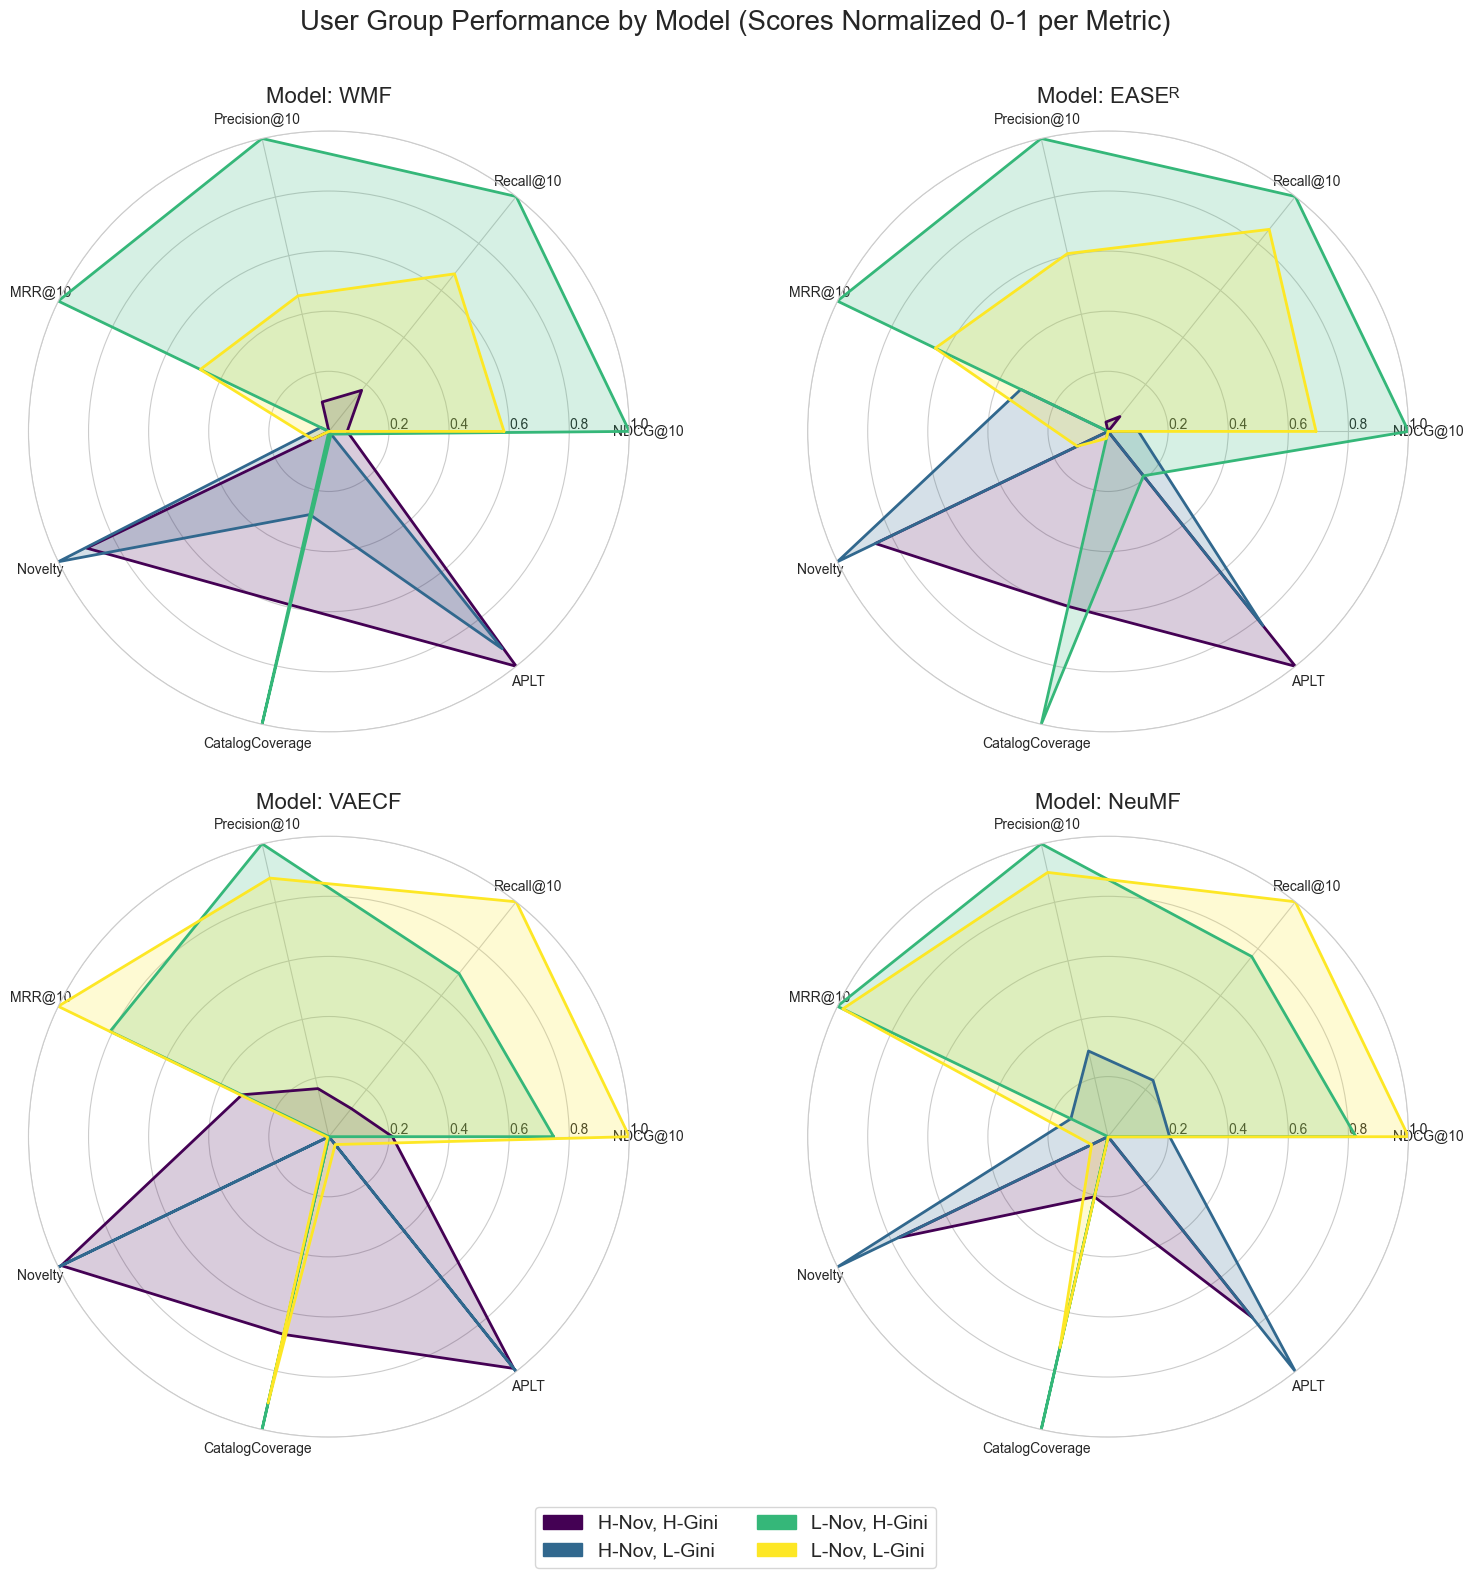

레이더 차트 저장 완료: ../results/book_crossing/20251112_book_crossing_result_summary_radar.png


In [60]:
try:
    corrected_data_path = Path(f"../{config['data_path']}")
    raw_df, eval_method, item_info = load_data(
        dataset_name=config['dataset_name'],
        path=corrected_data_path,
        split_config=config['data_split'],
        seed=config['seed'],
        verbose=False
    )
    train_set = eval_method.train_set
    print("데이터 로드 완료")
    
    anova_success = run_anova_analysis(train_set, item_info, dataset=DATASET_NAME, post_hoc=True)
    
    if anova_success:
        print("\n--- Radar Chart 플로팅 시작 ---")
        anova_plotting(dataset=DATASET_NAME)
    else:
        print("\nANOVA 분석 실패")

except FileNotFoundError as e:
    print(f"🚨 데이터 로딩 실패: {e}")
except Exception as e:
    print(f"🚨 예기치 않은 오류 발생: {e}")